# Exploring the Spatial Dynamics of Crime in Detroit: Assessing the Impact of Facilities and Police Station Proximity

## Introduction

Starting from the data on 911 calls, the project examines violent crimes committed in the city of Detroit over the past thirty days and their spatial distribution among the city's neighborhoods. It is hypothesized that the frequency of crimes is higher in proximity to certain categories of facilities. For example, it is more likely that a robbery will occur if you are near a bank. Conversely, it is also possible to hypothesize that there are facilities that serve as deterrents. For instance, the highest concentration of cultural and social services, as well as the presence of police stations, could lead to a reduction in crimes in their vicinity.

The data used for this study is available on Detroit's Open Data Portal and Data Driven Detroit. Data on facilities is downloaded from Open Street Maps. Every time the code is executed, the most up-to-date data is downloaded.

In this notebook, a geospatial exploration of the data with the visualization of informative maps is realized, followed by data processing, as well as the calculation of the distance between the locations of dangerous events and the nearest police station. Additionally, for each category of facility, the distance from the nearest one is calculated.

Furthermore, data on 911 calls are filtered as follows: only received calls (not made by operators) with the highest priority (emergency situations) and for which the neighborhood is known are considered.

Lastly, for informative purposes, two categories of violent crimes have been manually identified: those committed against property and those committed against individuals. Other categories, such as those related to traffic violations or mental health issues, are not considered for the current study.

## Related Studies

Studies in the literature emphasize the impact of crime generators, attractors, and facility proximity on crime distribution and urban planning. More specifically,  Bernasco and Block's (2011) work highlights the role of crime generators, attractors, and offender anchor points in influencing street robberies in Chicago.
Bowers (2014) research builds on these ideas by revealing how certain facilities can act as crime "radiators," exacerbating both internal and external theft. The study utilizes spatial regression and data from a UK Metropolitan area to establish a strong positive relationship between internal and external thefts, emphasizing the need to manage internal crime within these facilities to reduce overall crime rates.
Campedelli et al. (2023) expand our understanding by investigating the impact of events at the Prudential Center on crime in downtown Newark. This research highlights that certain event types are associated with increases in crime and emphasizes the importance of tailored safety policies based on event and location types, aligning with the concepts discussed by Patricia Brantingham and Paul Brantingham (1995) in their exploration of crime generators and attractors.


## Import modules

In [1]:
# Standard library imports
import zipfile
import io
import urllib.request
import os
from tqdm import tqdm

# Data manipulation and visualization libraries
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

# Geographic and spatial analysis libraries
import geopandas as gpd
import folium
import pyrosm
import osmnx as ox
import networkx as nx

# KernelDensity
from sklearn.neighbors import KernelDensity

# Utilities
import warnings
import requests
from matplotlib.patches import Patch
from folium.plugins import FastMarkerCluster
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from shapely.geometry import mapping
from scipy.spatial import cKDTree
from geopy.distance import geodesic
from shapely.ops import unary_union
from folium import IFrame
from branca.element import Element, Template

# Ignoring warning messages
warnings.simplefilter("ignore")


## Download Data

In [2]:
# Define a dictionary to store dataset information
datasets = {
    '911_Calls': {
        'url': 'https://data.detroitmi.gov/datasets/detroitmi::911-calls-for-service-last-30-days.zip',
        'zip_name': '911_Calls_for_Service_(Last_30_Days).zip'
    },
    'Neighborhoods': {
        'url': 'https://data.detroitmi.gov/datasets/7050ce421a4a46829e5e52219e174dc6_0.zip',
        'zip_name': 'Current_City_of_Detroit_Neighborhoods.zip'
    },
    'Police_stations':{
        'url': 'https://portal.datadrivendetroit.org/datasets/5ac217b684bd4aaead4bbe4b962f4073_0.zip',
        'zip_name':'Police_Stations,_Detroit,_2012-shp.zip'
    },
}

# Iterate through the datasets and download/extract the data
for dataset_name, dataset_info in datasets.items():
    directory_name = dataset_name

    # Check if the directory does not exist
    if not os.path.exists(directory_name):
        # If the directory does not exist, create it
        os.makedirs(directory_name)

    zip_file_url = dataset_info['url']
    zip_file_name = dataset_info['zip_name']

    # Download the data
    urllib.request.urlretrieve(zip_file_url, zip_file_name)

    # Unzip the file
    with zipfile.ZipFile(zip_file_name, 'r') as z:
        z.extractall(directory_name)
        z.close()

    # Remove the zip file after extraction if it's no longer needed
    os.remove(zip_file_name)

## Data Exploration

In [3]:
# Load the shapefile for 911 Calls for Service
calls_shapefile = '911_Calls//911_Calls_for_Service_(Last_30_Days).shp'
calls_data = gpd.read_file(calls_shapefile)

# Load the shapefile for Neighborhoods
neighborhoods_shapefile = 'Neighborhoods//Neighborhoods.shp'
neighborhoods_data = gpd.read_file(neighborhoods_shapefile)

In [4]:
# Display the first few rows of each dataset to understand their structures

# Applying the specified filters to the calls_data DataFrame
calls_data = calls_data.loc[
    (calls_data['officerini'] == 'No') & 
    (calls_data['priority'] == '1') &
    (calls_data['neighborho'].notna())
].dropna()

# Displaying columns of the filtered dataset
calls_data.columns

Index(['incident_i', 'agency', 'incident_a', 'zip_code', 'priority',
       'callcode', 'calldescri', 'category', 'call_times', 'precinct_s',
       'responding', 'officerini', 'intaketime', 'dispatchti', 'traveltime',
       'totalrespo', 'time_on_sc', 'totaltime', 'neighborho', 'block_id',
       'council_di', 'longitude', 'latitude', 'ObjectId', 'geometry'],
      dtype='object')

In [5]:
# Data Cleaning and Validation for the 911 Calls Data
# Checking for missing values
calls_data.isnull().sum().unique()

array([0], dtype=int64)

In [6]:
neighborhoods_data = neighborhoods_data.drop(columns=['Website'])
neighborhoods_data.head()

OBJECTID  council_di  nhood_num          nhood_name  SHAPE_Leng  \
0         1         4.0      103.0            West End    0.098727   
1         2         4.0      105.0       Chandler Park    0.063939   
2         3         4.0      100.0           Riverbend    0.074513   
3         4         4.0      101.0  Jefferson Chalmers    0.083501   
4         5         1.0       29.0           Riverdale    0.054555   

   SHAPE_Area                                           geometry  
0    0.000322  POLYGON ((-82.99152 42.38439, -82.99249 42.384...  
1    0.000220  POLYGON ((-82.97585 42.38933, -82.97603 42.389...  
2    0.000317  POLYGON ((-82.96784 42.38369, -82.96783 42.383...  
3    0.000399  POLYGON ((-82.95141 42.35503, -82.95292 42.354...  
4    0.000143  POLYGON ((-83.25748 42.41460, -83.25729 42.411...

In [7]:
print(any(neighborhoods_data.geometry.is_valid))
neighborhoods_data.geometry.crs

True


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [8]:
print(any(calls_data.geometry.is_valid))
calls_data.geometry.crs

True


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
# Prepare for Spatial Join
# Checking coordinate reference systems (CRS) compatibility
calls_crs = calls_data.crs
neighborhoods_crs = neighborhoods_data.crs

# Performing the spatial join if CRS are compatible
if calls_crs == neighborhoods_crs:
    joined_data = gpd.sjoin(calls_data, neighborhoods_data, how='left', predicate='within')
else:
    joined_data = None  # Placeholder in case the CRS do not match

In [10]:
joined_data['category'].unique()

array(['KIDNAP', 'RACE', 'OD', 'DISTURB', 'DV A/B', 'INVPERS', 'FA IP',
       'GSWCUT', 'SHOTS IP', 'SHOTSPT', 'BBUGIP', 'PRS WEAP', 'MISSSER',
       'ARSON', 'HI1 I/P', 'AB', 'SUICIP', 'ACCINJ', 'DDOT', 'ABUSE',
       'UNKPROB', 'HOLDUP', 'OOBVDEAD', 'NARCIP', 'WEAPON', 'ANMLCOMP',
       'ENTRY', 'HI2IP', 'INVAUTO', 'AIDMOTOR', 'HAZCON', 'VERALRM',
       'LARCENY', 'MAULING', 'MOLEST', 'RNAIP', 'BANKALRM', 'ACCUNK',
       'HRINJ', 'FIREALR', 'PANIC', 'HRUNK', 'LARCREPT', 'FRAUDIP',
       'MENTPPRS', 'RECAUTO', 'VEH', 'MNTLARM', 'RAIP', 'REMARKS',
       'BMBTHRT', 'MDPIP', 'OTHERSEX', 'PARK', 'VICANML', 'RAPE',
       'BBURGRPT', 'RESD', 'MNTLNARM', 'GSW1', 'WBC', 'UDAAIP', 'SCRP IP',
       'BURGALR', 'HOLDPERS', 'UDAAREPT', 'TRAFF1', 'FA RPT', 'RECAUTOF',
       'MISC TRF', 'TRAFF2', 'OVR', 'MDPRPT', 'BUSN', 'EXPLSION',
       'ACTVSHTR', 'VIPIP', 'SUICTHRT', 'FNDPERS', 'TRAFF3', 'AIDMOTR',
       'FELONY', 'AO', 'HI2RPT', 'WPNRPT', 'ABRPT', 'BEAUTO', 'PSYCH2',
       'SUSPPA

Let's define a more general categorization for violent events: 

In [11]:
incident_categories = {
    'Violence against people': ['DV A/B', 'HI1 I/P', 'GSWCUT', 'SHOTSPT', 'AB', 'ACCINJ', 'KIDNAP', 'SHOTS IP', 'ABUSE', 'RAPE', 'RNAIP', 'HRINJ', 'RAPERPT', 'HRUNK', 'HOLDPERS', 'MAULING', 'GSW2', 'HI2IP', 'HI2RPT', 'WPNRPT', 'OTHERSEX'],
    'Traffic Violation': ['RACE', 'PARK', 'OVR', 'TRAFF2', 'DDOT', 'ACCREPT', 'ACCUNK', 'INVAUTO', 'TRAFF1', 'TRAFF3', 'MISC TRF', 'RECAUTO', 'RECAUTOF', 'MNTLNARM'],
    'Violence against property': ['LARCREPT', 'SCRP IP', 'BEAUTO', 'ARSON', 'HOLDUP', 'BEAUTORP', 'FIREALR', 'BANKALRM', 'BURGALR', 'BMBTHRT', 'BUSN', 'BBURGRPT', 'EXPLSION', 'ACTVSHTR', 'AIDMOTR', 'FELONY'],
    'Mental Health Emergency - Suicide': ['OD', 'SUICIP', 'WBC', 'MENTPPRS', 'PPOIP', 'MNTLARM', 'SUICIDETHREAT'],
}

# Define the function to map categories
def map_category(category):
    for crime_category, crime_list in incident_categories.items():
        if category in crime_list:
            return crime_category
    return "Other"  # If the category doesn't match any defined categories

# Apply the mapping function to create a new column
joined_data['crime_category'] = joined_data['category'].apply(map_category)

joined_data['crime_category'].unique()

array(['Violence against people', 'Traffic Violation',
       'Mental Health Emergency - Suicide', 'Other',
       'Violence against property'], dtype=object)

In [12]:
joined_data['crime_category'].value_counts()

Violence against people              3306
Other                                3162
Violence against property             286
Mental Health Emergency - Suicide     241
Traffic Violation                     128
Name: crime_category, dtype: int64

In [13]:
filtered_data = joined_data.loc[joined_data['crime_category'].isin(['Violence against people', 'Violence against property'])]

In [14]:

def custom_round(x):
    # Define the custom rounding function
    decimal_part = x - int(x)
    if abs(decimal_part) < 0.5:
        return int(x)
    else:
        return int(x) + 1

def adjust_total_to_100(result_df):
    # Create a copy of the DataFrame to avoid modifying the original
    adjusted_df = result_df.copy()

    # Iterate through each row (neighborhood)
    for idx, row in adjusted_df.iterrows():
        total_count = row.sum()

        # Check if the total count is not equal to 100
        if total_count != 100:
            adjustment = 100 - total_count

            # Find the maximum value and its column
            max_value = row.max()
            max_column = row.idxmax()

            # Adjust the maximum value by adding or subtracting the adjustment
            adjusted_df.at[idx, max_column] += adjustment

    # Ensure that the total count is now unique and equal to 100 for all neighborhoods
    unique_total_counts = adjusted_df.sum(axis=1).unique()

    return adjusted_df

def process_data(filtered_data):
    # Assuming you have the grouped Series 'prova'
    prova = filtered_data.groupby(['nhood_name', 'crime_category']).size()

    # Convert the Series to a DataFrame
    result_df = prova.reset_index()
    result_df.columns = ['nhood_name', 'crime_category', 'count']

    # Pivot the DataFrame to create separate columns for each crime category
    result_df = result_df.pivot(index='nhood_name', columns='crime_category', values='count')

    # Fill NaN values with 0 (in case some neighborhoods have no data for a particular category)
    result_df = result_df.fillna(0)
    
    people_crimes = result_df['Violence against people']
    property_crimes = result_df['Violence against property']

    # Calculate the sum of counts for each neighborhood
    result_df['ncrimes'] = result_df.sum(axis=1)

    # Divide each count by the total count and multiply by 100 to get the percentage
    for col in result_df.columns[:-1]:
        result_df[col] = (result_df[col] / result_df['ncrimes']) * 100

    # Apply the custom rounding function to all the DataFrame values
    result_df = result_df.applymap(custom_round)

    save_column = result_df['ncrimes']

    # Drop the 'total_count' column if you no longer need it
    result_df = result_df.drop(columns='ncrimes')

    # Call the adjustment function
    adjusted_result_df = adjust_total_to_100(result_df)

    adjusted_result_df['ncrimes'] = save_column

    adjusted_result_df['people_crimes'] = people_crimes.astype('int')
    adjusted_result_df['property_crimes'] = property_crimes.astype('int')

    return adjusted_result_df

# Call the function with your DataFrame
adjusted_result_df = process_data(filtered_data)
adjusted_result_df.head(10)

crime_category     Violence against people  Violence against property  \
nhood_name                                                              
Airport Sub                            100                          0   
Aviation Sub                           100                          0   
Bagley                                  79                         21   
Barton-McFarland                        97                          3   
Belmont                                100                          0   
Berg-Lahser                             94                          6   
Bethune Community                       85                         15   
Blackstone Park                        100                          0   
Boston Edison                          100                          0   
Boynton                                 92                          8   

crime_category     ncrimes  people_crimes  property_crimes  
nhood_name                                                  
Airport Sub             32             32                0  
Aviation Sub             9              9                0  
Bagley                  19             15                4  
Barton-McFarland        31             30                1  
Belmont                 17             17                0  
Berg-Lahser             18             17                1  
Bethune Community       62             53                9  
Blackstone Park          1              1                0  
Boston Edison            5              5                0  
Boynton                 24             22                2

In [15]:
neighborhoods_data = pd.merge(neighborhoods_data, adjusted_result_df, left_on='nhood_name', right_index=True)

In [17]:
# Convert the GeoDataFrame to GeoJSON format
neighborhoods_geojson = neighborhoods_data.to_json()

# Create a base map, centered around the mean of the latitudes and longitudes of the neighborhoods
m = folium.Map(
    location=[
        neighborhoods_data.geometry.centroid.y.mean(),
        neighborhoods_data.geometry.centroid.x.mean()
    ],
    zoom_start=12  # zoom level
)

# Add the neighborhoods to the map with a choropleth layer
folium.Choropleth(
    geo_data=neighborhoods_geojson,
    name='choropleth',
    data=neighborhoods_data,
    columns=['nhood_name', 'ncrimes'],
    key_on='feature.properties.nhood_name',
    fill_color='YlGnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Crime Rate'
).add_to(m)

# Add a GeoJson layer to allow for the interactive display of neighborhood names and crime numbers on hover
folium.GeoJson(
    neighborhoods_geojson,
    name='Neighborhoods',
    style_function=lambda x: {'color':'transparent', 'fillColor':'transparent', 'weight':0},
    tooltip=folium.GeoJsonTooltip(
        fields=['nhood_name', 'ncrimes', 'Violence against people', 'Violence against property'],  # The fields from GeoJSON to be displayed in the tooltip
        aliases=['Neighborhood:', 'Number of Crimes:', 'Violence against people (%):', 'Violence against property (%):'],  # The aliases for those fields
        localize=True
    )
).add_to(m)


# Add layer control to toggle the choropleth
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save('interactive_neighborhoods_map.html')

m

### Points of Interest

In [18]:
detroit_download_pbf_url = "https://download.geofabrik.de/north-america/us/michigan-latest.osm.pbf"

# Request the file
r = requests.get(detroit_download_pbf_url, allow_redirects=True)

# Check if the request was successful
if r.status_code == 200:
    with open('michigan.pbf', 'wb') as file:
        file.write(r.content)

In [19]:
bounding_box = [-83.287959,42.255192,-82.910439,42.450239] # detroit
osm = pyrosm.OSM("michigan.pbf", bounding_box=bounding_box)
osm.conf.tags.available

['aerialway',
 'aeroway',
 'amenity',
 'boundary',
 'building',
 'craft',
 'emergency',
 'geological',
 'highway',
 'historic',
 'landuse',
 'leisure',
 'natural',
 'office',
 'power',
 'public_transport',
 'railway',
 'route',
 'place',
 'shop',
 'tourism',
 'waterway']

In [20]:
osm.conf.tags.amenity

['addr:city',
 'addr:country',
 'addr:full',
 'addr:housenumber',
 'addr:housename',
 'addr:postcode',
 'addr:place',
 'addr:street',
 'email',
 'name',
 'opening_hours',
 'operator',
 'phone',
 'ref',
 'url',
 'visible',
 'website',
 'yes',
 'amenity',
 'arts_centre',
 'atm',
 'bank',
 'bicycle_parking',
 'bicycle_rental',
 'bicycle_repair_station',
 'bar',
 'bbq',
 'biergarten',
 'brothel',
 'building',
 'building:levels',
 'bureau_de_change',
 'bus_station',
 'bus_stop',
 'cafe',
 'car_rental',
 'car_repair',
 'car_sharing',
 'car_wash',
 'casino',
 'charging_station',
 'childcare',
 'cinema',
 'clinic',
 'college',
 'dentist',
 'doctors',
 'driving_school',
 'drinking_water',
 'fast_food',
 'ferry_terminal',
 'fire_station',
 'food_court',
 'fountain',
 'fuel',
 'gambling',
 'hospital',
 'ice_cream',
 'internet_access',
 'kindergarten',
 'landuse',
 'language_school',
 'library',
 'music_school',
 'nightclub',
 'nursing_home',
 'office',
 'operator',
 'parking',
 'pharmasy',
 'plan

In [21]:
detroit_pois = osm.get_pois(custom_filter={"amenity": ['cafe', 'school', 'kindergarten', 'clinic', 'hospital', 'arts_centre',
                                                       'doctors', 'library', 'pharmacy', 'restaurant', 'theatre',
                                                       'bar', 'fast_food', 'bank', 'pub', 'ice_cream', 'atm', 
                                                       'dentist', 'food_court', 'childcare', 'college', 'university', 
                                                       'music_school', 'cinema', 'social_centre', 'social_facility']})

In [22]:
detroit_pois = detroit_pois[['id', 'lon', 'lat', 'amenity', 'geometry', 'osm_type']].loc[detroit_pois['osm_type'] == 'node']

In [23]:
# Perform a spatial join
detroit_pois = gpd.sjoin(detroit_pois, neighborhoods_data, op='within', how='inner')

# Filter the points in detroit_pois that belong to neighborhoods
points_in_neighborhoods = detroit_pois[detroit_pois.index.isin(detroit_pois.index_right)]

detroit_pois = detroit_pois[['id', 'lon', 'lat', 'amenity', 'geometry', 'nhood_name']]

In [24]:
# Create a dictionary to categorize amenities
amenity_categories = {
    'theatre':'social-cultural',
    'hospital':'healthcare',
    'cafe': 'food and drink',
    'school': 'education',
    'kindergarten': 'education',
    'clinic': 'healthcare',
    'doctors': 'healthcare',
    'library': 'education',
    'pharmacy': 'healthcare',
    'restaurant': 'food and drink',
    'bar': 'food and drink',
    'fast_food': 'food and drink',
    'bank': 'finance',
    'pub': 'food and drink',
    'ice_cream': 'food and drink',
    'atm': 'finance',
    'dentist': 'healthcare',
    'food_court': 'food and drink',
    'childcare': 'social-cultural',
    'college': 'education',
    'university': 'education',
    'music_school': 'education',
    'cinema':'social-cultural',
    'arts_centre':'social-cultural',
    'social_centre':'social-cultural', 
    'social_facility':'social-cultural'
}

detroit_pois['amenity_categories'] = detroit_pois['amenity'].map(amenity_categories)

In [25]:
detroit_pois['amenity_categories'].unique()

array(['education', 'social-cultural', 'food and drink', 'healthcare',
       'finance'], dtype=object)

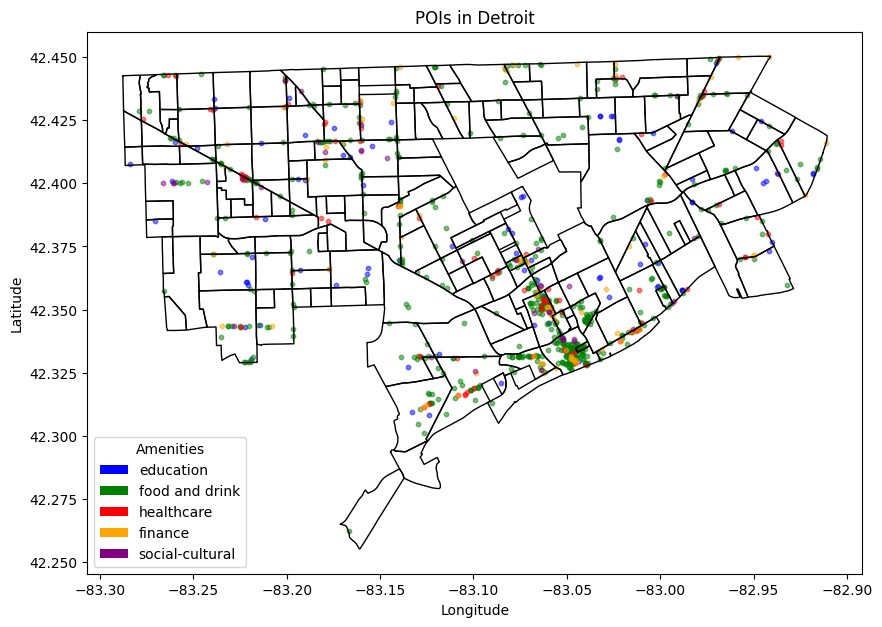

In [26]:
# Create a colormap for the reduced categories
colormap = {
    'education': 'blue',
    'food and drink':'green',
    'healthcare': 'red',
    'finance': 'orange',
    'social-cultural':'purple',
}

detroit_pois['color'] = detroit_pois['amenity_categories'].map(colormap)

# Mapping amenities
fig, ax = plt.subplots(figsize=(10, 10))

# Plot points using the colormap and categories
for category, color in colormap.items():
    detroit_pois[detroit_pois['amenity_categories'] == category].plot(ax=ax, markersize=10, color=color, label=category, alpha=0.5)

neighborhoods_data.plot(ax=ax, facecolor='none', edgecolor='black', label='Neighborhoods')

plt.title('POIs in Detroit')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Create a legend with all the colors
legend_elements = [Patch(facecolor=color, label=category) for category, color in colormap.items()]
ax.legend(handles=legend_elements, title='Amenities')

plt.show()

In [27]:
detroit_pois.amenity_categories.value_counts()

food and drink     586
education           87
healthcare          86
finance             82
social-cultural     37
Name: amenity_categories, dtype: int64

### Inspecting the Inpact of Facilities on violent crimes

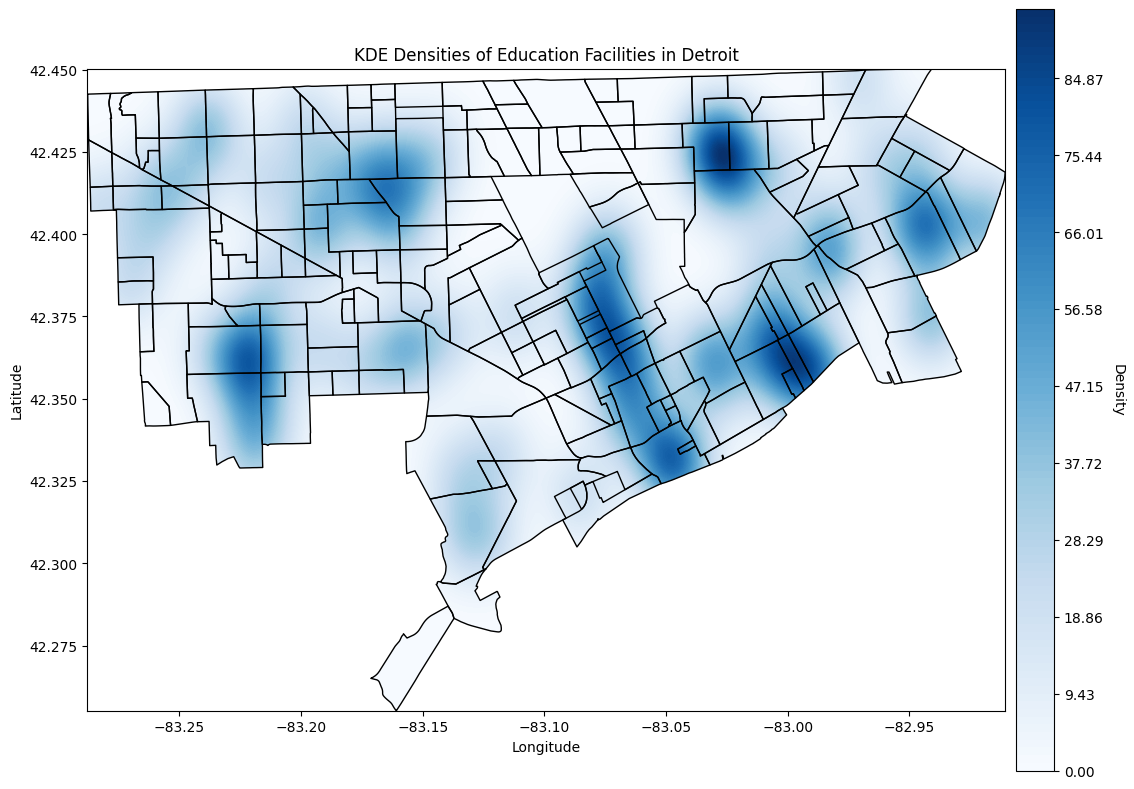

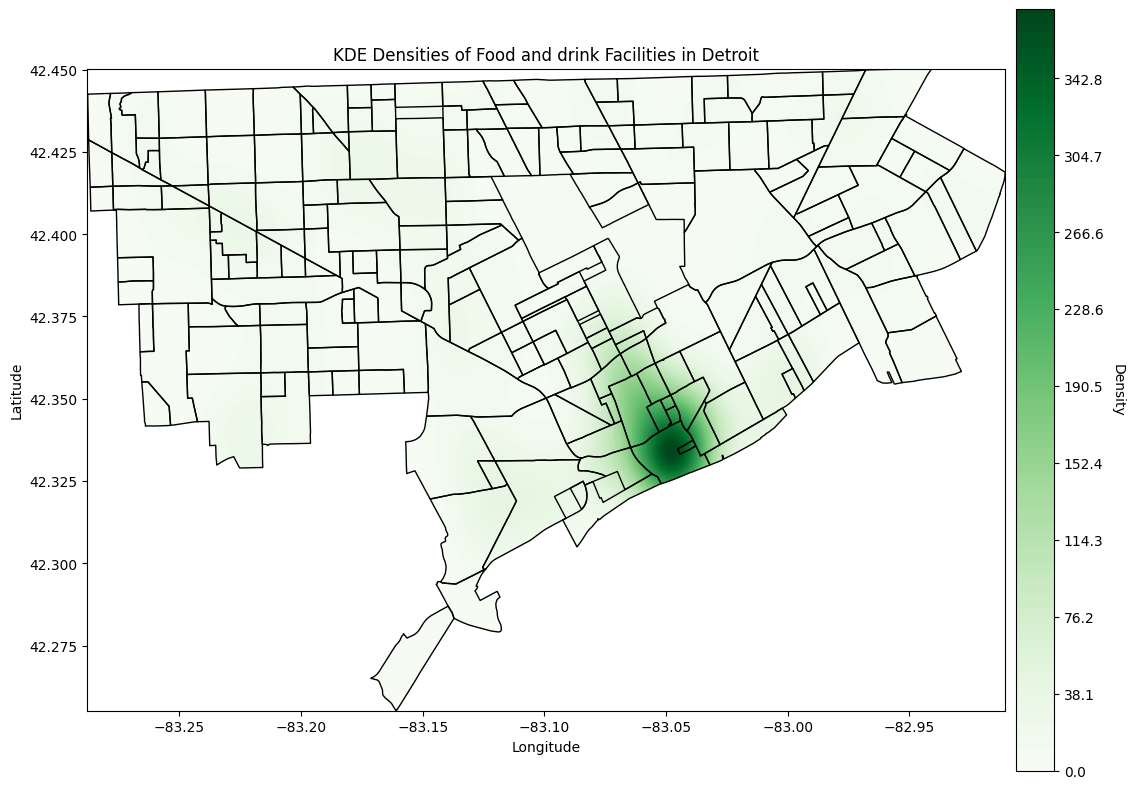

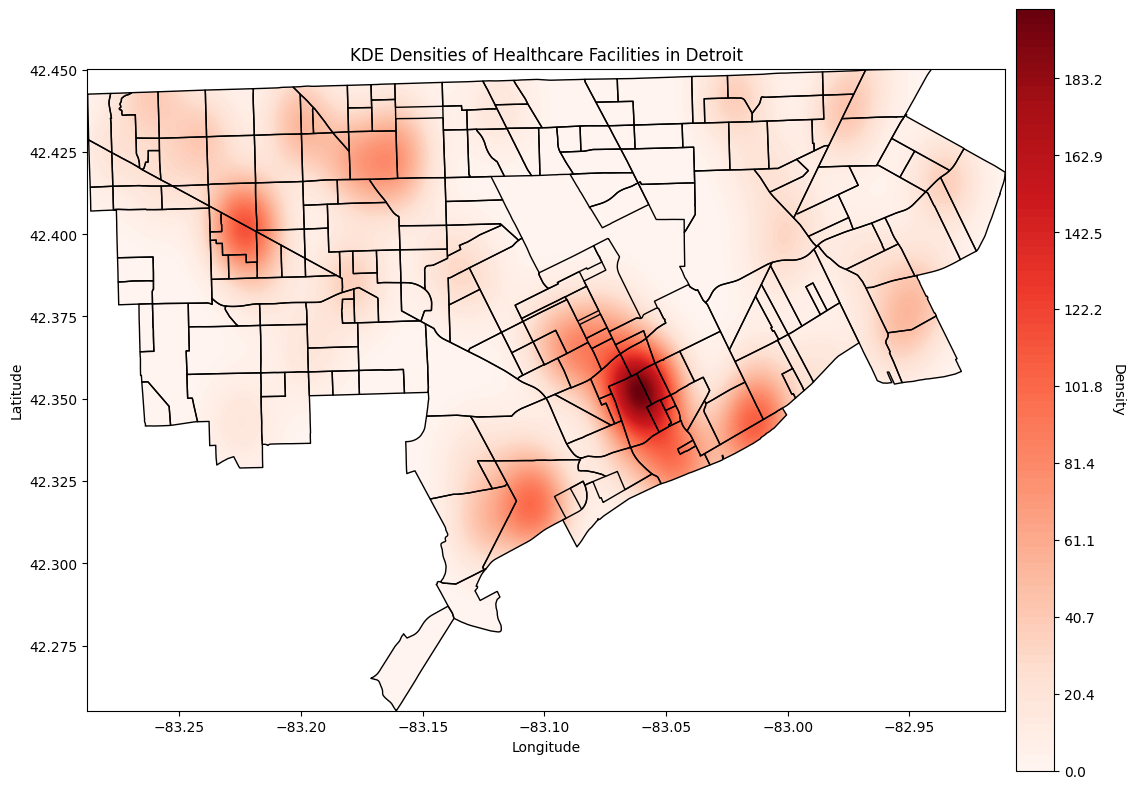

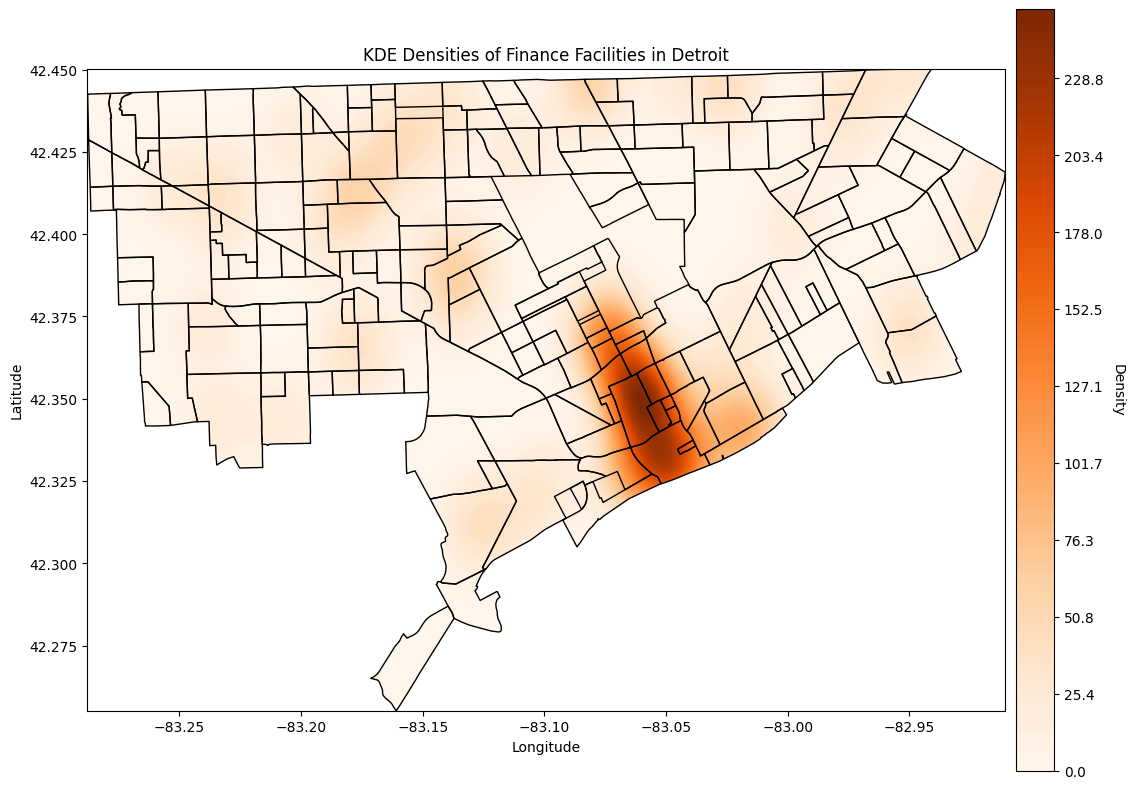

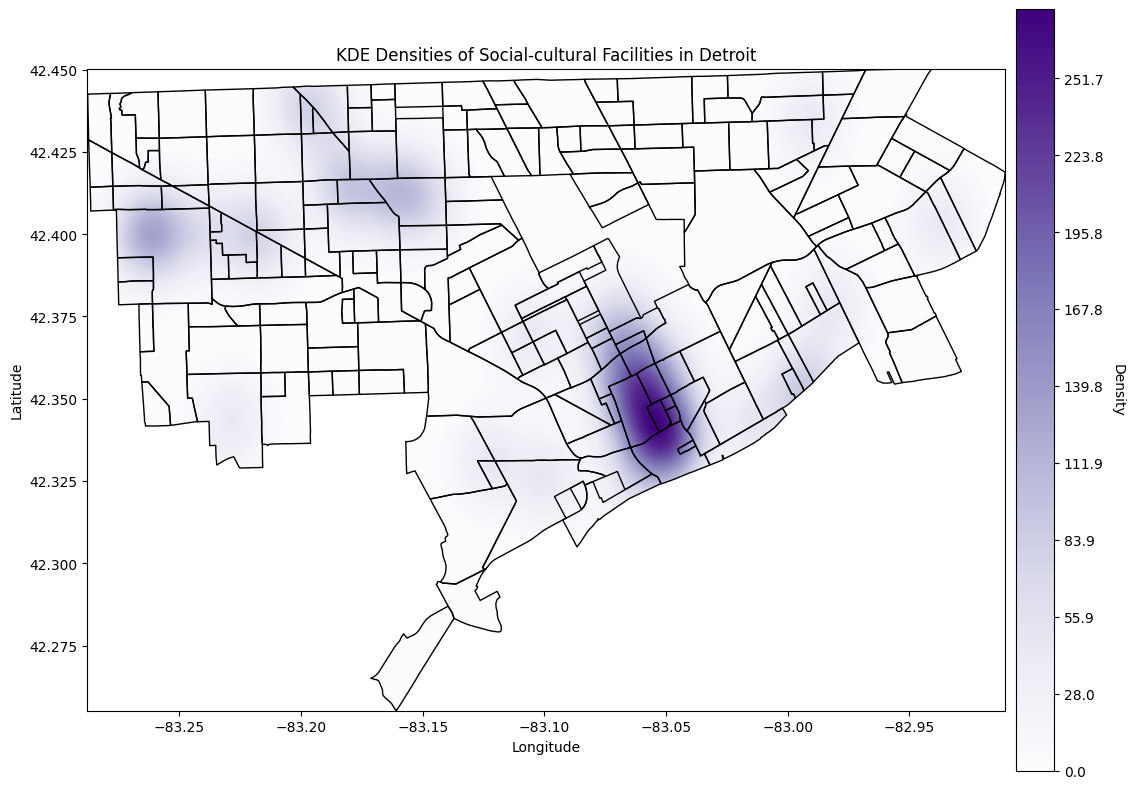

In [28]:
# Define a colormap for the reduced categories
colormap = {
    'education': 'Blues',
    'food and drink': 'Greens',
    'healthcare': 'Reds',
    'finance': 'Oranges',
    'social-cultural': 'Purples',
}

kde_results = {}  # Dictionary to store KDE results

# Increase the number of grid points for finer resolution
grid_points = 200  # More grid points for finer resolution

# Get the city boundary as a Path for masking
city_boundary_polygon = neighborhoods_data.unary_union  # if you have multiple polygons
city_boundary_path = Path(np.array(city_boundary_polygon.exterior.coords))

# Loop through each category of facilities to create separate KDE plots
for category, cmap_name in colormap.items():
    # Filter facilities by category
    facilities_category = detroit_pois[detroit_pois['amenity_categories'] == category]
    
    # Extract coordinates as numpy array
    coordinates = np.array(facilities_category[['lat', 'lon']])
    
    # Calculate the KDE
    kde = KernelDensity(bandwidth=0.01)  # Optimize this value as needed
    kde.fit(coordinates)
    
    # Create a grid for the entire Detroit map
    x_map, y_map = np.meshgrid(np.linspace(city_boundary_polygon.bounds[0], city_boundary_polygon.bounds[2], grid_points),
                               np.linspace(city_boundary_polygon.bounds[1], city_boundary_polygon.bounds[3], grid_points))
    
    # Evaluate the densities on the map grid
    xy = np.vstack([y_map.ravel(), x_map.ravel()]).T
    z_map = np.exp(kde.score_samples(xy)).reshape(x_map.shape)

    # Store KDE results in the dictionary
    kde_results[category] = (x_map, y_map, z_map)
    
    # Initialize a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot the KDE as a filled contour map
    contour = ax.contourf(x_map, y_map, z_map, cmap=cmap_name, levels=np.linspace(z_map.min(), z_map.max(), 100))

    # Create a PathPatch from the city boundary path
    city_patch = PathPatch(city_boundary_path, transform=ax.transData, edgecolor='none', facecolor='none')

    # Add the city boundary PathPatch to the axes
    ax.add_patch(city_patch)
    
    # Clip the contour with the city boundary PathPatch
    for collection in contour.collections:
        collection.set_clip_path(city_patch)
    
    # Plot the neighborhoods map with city boundary
    neighborhoods_data.boundary.plot(ax=ax, linewidth=1, edgecolor='black')

    # Add a colorbar for the densities
    cbar = plt.colorbar(contour, ax=ax, label='Density', pad=0.01)
    cbar.ax.set_ylabel('Density', rotation=270, labelpad=15)
    
    # Customize the plot as needed
    plt.title(f'KDE Densities of {category.capitalize()} Facilities in Detroit')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [29]:
# Function to calculate haversine distance between two coordinates
def haversine_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

# Create a dictionary to store normalized distances for each category
normalized_distances = {category: [] for category in colormap.keys()}

# Convert facility coordinates to a NumPy array
facility_coords = {
    category: np.array(detroit_pois[detroit_pois['amenity_categories'] == category][['lat', 'lon']])
    for category in colormap.keys()
}

# Create KD-Trees for fast nearest-neighbor lookup
kdtrees = {
    category: cKDTree(np.vstack((x_map.ravel(), y_map.ravel())).T)
    for category, (x_map, y_map, _) in kde_results.items()
}

# Iterate through each accident in filtered_data with a progress bar
for index, accident in tqdm(filtered_data.iterrows(), total=len(filtered_data)):

    accident_coords = (accident['latitude'], accident['longitude'])
    
    # Iterate through each facility category
    for category in colormap.keys():
        distances = [haversine_distance(accident_coords, tuple(coord)) for coord in facility_coords[category]]
        
        if not distances:
            # Handle case where there are no facilities in the category
            normalized_distance = None
        else:
            # Find the nearest facility index
            nearest_facility_index = np.argmin(distances)

            x, y = kdtrees[category].data[kdtrees[category].query([accident['longitude'], accident['latitude']])[1]]

            idx = np.where(kde_results[category][0][0] == x)[0][0]

            kde_value = kde_results[category][2][idx][idx]
            
            normalized_distance = distances[nearest_facility_index] / kde_value
        
        # Append the normalized distance to the corresponding category
        normalized_distances[category].append(normalized_distance)

# Add normalized distances as columns to joined_data
for category in colormap.keys():
    filtered_data[f'normdist_{category}'] = normalized_distances[category]


100%|██████████| 3592/3592 [08:46<00:00,  6.82it/s]


In [30]:
distances = {category: [] for category in colormap.keys()}

# Iterate through each accident in filtered_data with a progress bar
for index, accident in tqdm(filtered_data.iterrows(), total=len(filtered_data)):

    accident_coords = (accident['latitude'], accident['longitude'])
    
    # Iterate through each facility category
    for category in colormap.keys():
        facility_distances = [haversine_distance(accident_coords, tuple(coord)) for coord in facility_coords[category]]
        
        if not facility_distances:
            # Handle case where there are no facilities in the category
            distance = None
        else:
            # Find the minimum distance to a facility in the category
            distance = min(facility_distances)
        
        # Append the distance to the corresponding category
        distances[category].append(distance)

# Add distance columns to joined_data
for category in colormap.keys():
    filtered_data[f'distance_{category}'] = distances[category]


100%|██████████| 3592/3592 [08:51<00:00,  6.76it/s]


### Streets with the highest occurence of crime in the last month

In [31]:
# Group by the 'incident_a' column and count the number of occurrences
crime_counts = filtered_data['incident_a'].value_counts().head(5)

# Display the top 5 streets or areas with the highest crime counts
crime_counts

Michigan Ave & Cass Ave       10
Pallister St & 3rd St          9
Seminole St & E Forest Ave     8
Hoover St & 8 Mile Rd          8
Schaefer & Schaefer Hwy        7
Name: incident_a, dtype: int64

In [32]:
# Extract the names of the top 5 streets or intersections
top_streets = crime_counts.index.tolist()

# Filter the original GeoDataFrame to include only incidents from the top 5 streets
top_streets_gdf = filtered_data[filtered_data['incident_a'].isin(top_streets)]

# Group the filtered GeoDataFrame by 'incident_a' and aggregate the geometries
grouped_top_streets = top_streets_gdf.groupby('incident_a')['geometry'].agg(unary_union)

# Find the centroid of the aggregated geometries to get a representative point for each top street
rep_points_top_streets = grouped_top_streets.centroid

# Create a new GeoDataFrame for the representative points of the top streets
rep_points_top_streets_gdf = gpd.GeoDataFrame(geometry=rep_points_top_streets)

rep_points_top_streets_gdf

geometry
incident_a                                            
Hoover St & 8 Mile Rd       POINT (-83.00519 42.44883)
Michigan Ave & Cass Ave     POINT (-83.05267 42.33168)
Pallister St & 3rd St       POINT (-83.08143 42.37060)
Schaefer & Schaefer Hwy     POINT (-83.17729 42.35369)
Seminole St & E Forest Ave  POINT (-83.00815 42.37503)

In [33]:
# Perform a spatial join between the representative points and the neighborhoods
# This will add the neighborhood information to each representative point
rep_points_with_neighborhoods = gpd.sjoin(rep_points_top_streets_gdf, neighborhoods_data, how="left", op='within')

# Load the shapefile for Neighborhoods
police_stations_file = 'Police_stations//92d6ebdb-81f7-4a50-a5a6-af1f2730e94c2020329-1-8yyqst.0n1vb.shp'
police_stations = gpd.read_file(police_stations_file)

boundaries = 'Boundaries//City_of_Detroit_Boundary.shp'

# Recreate the base map
m = folium.Map(
    location=[
        neighborhoods_data.geometry.centroid.y.mean(),
        neighborhoods_data.geometry.centroid.x.mean()
    ],
    zoom_start=12  # zoom level
)

# Iterate over the spatially joined GeoDataFrame to add each point to the map
# Include the street name, incident count, and neighborhood name in the popup
for idx, row in rep_points_with_neighborhoods.iterrows():
    # Get the number of incidents for the current street/intersection
    incident_count = crime_counts.loc[idx.split("_")[0]]  # Splitting idx to get the original street name
    
    # Create the popup text including neighborhood name
    popup_text = f"Street: {idx.split('_')[0]}<br>Incidents: {incident_count}<br>Neighborhood: {row['nhood_name']}"
    
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=folium.Popup(popup_text, max_width=300),
        icon=folium.Icon(color='red', icon='star')
    ).add_to(m)

# Iterate over the police stations GeoDataFrame to add each station to the map
for idx, row in police_stations.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Police Station: {row['Address']}",
        icon=folium.Icon(color='blue', icon='shield')
    ).add_to(m)

# Custom HTML code for the legend
legend_html = '''
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 80px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     opacity: 0.9">
     &nbsp;<b>Legend</b><br>
     &nbsp;<i class="fa fa-shield" style="color:blue"></i>&nbsp;Police Station<br>
     &nbsp;<i class="fa fa-star" style="color:red"></i>&nbsp;Crime Incident<br>
     </div>
     '''

# Create a Template which holds the HTML code
legend = Element(legend_html)

# Add the HTML code to the map
m.get_root().html.add_child(legend)

# Display the updated map with the representative points, incident counts, neighborhood information, and police stations
m

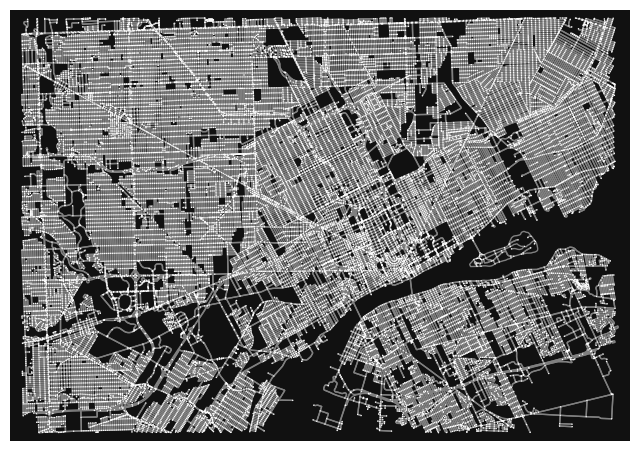

In [34]:
# Download the street network for the area of interest
# Define the bounding box for Detroit
west, south, east, north = -83.287959, 42.255192, -82.910439, 42.450239

# Download the street network for Detroit within the defined bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Plot the street network of the city of Detroit
fig, ax = ox.plot_graph(G, node_size=1, edge_linewidth=1, edge_color='gray')

In [35]:
# Configure OSMnx to use drive network type
ox.config(use_cache=True, log_console=True)
network_type = 'drive'

top_incidents = rep_points_top_streets_gdf

# Find the nearest network node to each incident and police station
top_incidents['nearest_node'] = top_incidents.apply(lambda row: ox.nearest_nodes(G, row.geometry.x, row.geometry.y), axis=1)
police_stations['nearest_node'] = police_stations.apply(lambda row: ox.nearest_nodes(G, row.geometry.x, row.geometry.y), axis=1)

# For each top incident, find the nearest police station and calculate the shortest path
for idx, incident in top_incidents.iterrows():
    incident_node = incident['nearest_node']
    
    # Calculate distance to all police stations and find the nearest
    police_stations['distance'] = police_stations['nearest_node'].apply(lambda x: nx.shortest_path_length(G, incident_node, x, weight='length'))
    nearest_station = police_stations.loc[police_stations['distance'].idxmin()]
    
    # Calculate the shortest path to the nearest police station
    shortest_path = nx.shortest_path(G, incident_node, nearest_station['nearest_node'], weight='length')

As an example, let's plot the shortest path between a police station and an accident.

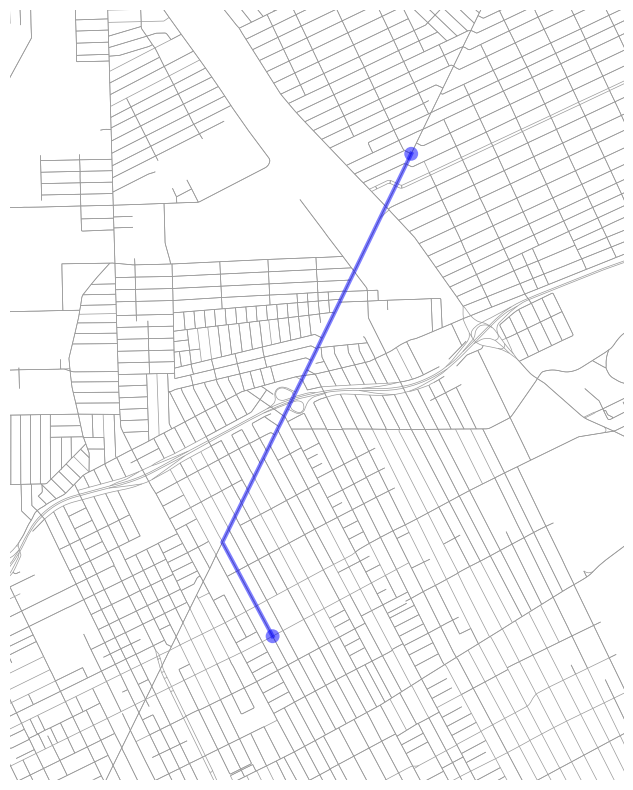

In [36]:
# Get the nodes in the shortest path
path_nodes = [G.nodes[node] for node in shortest_path]

# Calculate the bounding box around the path nodes
north = max(node['y'] for node in path_nodes)
south = min(node['y'] for node in path_nodes)
east = max(node['x'] for node in path_nodes)
west = min(node['x'] for node in path_nodes)

# Define the bounding box margin to add some space around the route
margin = 0.01  # Adjust the margin size as needed

# Create a figure and axis with a specific size
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the graph with the street network on the specified axis
# This adds the street map in the background
ox.plot_graph(
    G, 
    ax=ax, 
    bbox=(north + margin, south - margin, east + margin*2, west - margin*2),
    node_size=0, 
    edge_linewidth=0.5,  # Adjust the linewidth of the streets if needed
    show=False, 
    close=False
)

# Overlay the shortest path route on the same axis to keep the street map in the background
ox.plot_graph_route(
    G, shortest_path, 
    ax=ax, 
    route_color='blue', 
    route_linewidth=3,  # Customize route color and linewidth
    node_size=0  # Hide the nodes on the route for better clarity
)

# Display the plot
plt.show()

### Calculating distances between police stations and crime locations

In [37]:
import geopy.distance

# Configure OSMnx to use drive network type
ox.settings.use_cache = True
ox.settings.log_console = True
network_type = 'drive'

# # Define the bounding box for Detroit
# west, south, east, north = -83.287959, 42.255192, -82.910439, 42.450239

# # Download the street network for Detroit within the defined bounding box
# G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Find the nearest network node to each incident and police station
filtered_data['nearest_node'] = filtered_data.apply(lambda row: ox.nearest_nodes(G, row.geometry.x, row.geometry.y), axis=1)
police_stations['nearest_node'] = police_stations.apply(lambda row: ox.nearest_nodes(G, row.geometry.x, row.geometry.y), axis=1)

# Create a dictionary to store the coordinates of incident nodes
incident_coordinates = {node: (G.nodes[node]['y'], G.nodes[node]['x']) for node in filtered_data['nearest_node']}

# Create a dictionary to store the coordinates of police station nodes
police_station_coordinates = {node: (G.nodes[node]['y'], G.nodes[node]['x']) for node in police_stations['nearest_node']}

# Calculate distances for all incidents to all police stations
distances_matrix = np.zeros((len(filtered_data), len(police_stations)))
for i, incident_node in enumerate(tqdm(filtered_data['nearest_node'])):
    incident_coords = incident_coordinates[incident_node]
    for j, police_station_node in enumerate(police_stations['nearest_node']):
        police_station_coords = police_station_coordinates[police_station_node]
        distances_matrix[i, j] = geopy.distance.distance(incident_coords, police_station_coords).km

# Find the nearest police station for each incident
nearest_police_stations = np.argmin(distances_matrix, axis=1)
filtered_data['police_station_d'] = [distances_matrix[i, nearest_station] for i, nearest_station in enumerate(nearest_police_stations)]

100%|██████████| 3592/3592 [00:04<00:00, 749.11it/s]


In [38]:
# Calculate the average for each specified column group by 'nhood_name'
averages = filtered_data.groupby('nhood_name')[[
    'normdist_education', 'normdist_food and drink', 'normdist_healthcare',
    'normdist_finance', 'normdist_social-cultural', 'distance_education',
    'distance_food and drink', 'distance_healthcare', 'distance_finance',
    'distance_social-cultural', 'police_station_d'
]].mean().reset_index()

In [39]:
# Merge the averages DataFrame with the neighborhoods_data DataFrame on 'nhood_name'
neighborhoods_data = neighborhoods_data.merge(averages, on='nhood_name', how='left')

In [73]:
df = neighborhoods_data[['nhood_name', 'geometry', 'ncrimes', 'distance_education', 
                         'distance_food and drink', 'distance_healthcare',
                         'distance_finance', 'distance_social-cultural', 'police_station_d']]

In [74]:
df = df.rename(columns={
    'distance_education':'education', 
    'distance_food and drink':'food_drink', 
    'distance_healthcare':'healthcare',
    'distance_finance':'finance', 
    'distance_social-cultural':'socio_cultural', 
    'police_station_d':'police_station'
})

In [75]:
# for data analysis
df.to_file('crime_detroit.shp')

## Data Analysis Results

The Moran's I test was significant at the 0.05 level, indicating spatial autocorrelation in the number of crimes between neighborhoods.

Spatial regression modeling was conducted to account for the complex spatial dynamics of crime distribution in Detroit, particularly in relation to various types of facilities. This approach helps to understand how the presence or absence of certain facilities impacts crime rates in nearby areas, considering both the attraction and deterrent effects. The model aims to accurately capture these spatial dependencies, allowing for a nuanced understanding of urban crime patterns and informing effective urban planning and public safety strategies.

In conducting spatial regression, it's essential to understand whether the phenomenon under study is likely to generate local spatial spillovers or global spatial spillovers. Results suggest a local spatial spillover, as SDM was the model fitting the data the best. 


### Spatial Durbin Model (SDM) Results

<table class="table table-striped table-hover">
    <thead>
        <tr>
            <th>Term</th>
            <th>Estimate</th>
            <th>Std. Error</th>
            <th>z value</th>
            <th>Pr(&gt;|z|)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>(Intercept)</td>
            <td>14.7849</td>
            <td>6.8375</td>
            <td>2.1623</td>
            <td>0.030594</td>
        </tr>
        <tr>
            <td>education</td>
            <td>2.4041</td>
            <td>3.6103</td>
            <td>0.6659</td>
            <td>0.505466</td>
        </tr>
        <tr>
            <td>food_drink</td>
            <td>-4.6330</td>
            <td>5.1441</td>
            <td>-0.9006</td>
            <td>0.367779</td>
        </tr>
        <tr>
            <td>healthcare</td>
            <td>-1.1928</td>
            <td>3.2861</td>
            <td>-0.3630</td>
            <td>0.716610</td>
        </tr>
        <tr>
            <td>finance</td>
            <td>-2.6204</td>
            <td>3.1110</td>
            <td>-0.8423</td>
            <td>0.399617</td>
        </tr>
        <tr>
            <td>socio_cult</td>
            <td>-6.4765</td>
            <td>3.2110</td>
            <td>-2.0169</td>
            <td>0.043703</td>
        </tr>
        <tr>
            <td>police_sta</td>
            <td>8.0499</td>
            <td>2.8560</td>
            <td>2.8186</td>
            <td>0.004823</td>
        </tr>
        <tr>
            <td>lag.education</td>
            <td>-9.9946</td>
            <td>5.6008</td>
            <td>-1.7845</td>
            <td>0.074342</td>
        </tr>
        <tr>
            <td>lag.food_drink</td>
            <td>4.4518</td>
            <td>9.2711</td>
            <td>0.4802</td>
            <td>0.631096</td>
        </tr>
        <tr>
            <td>lag.healthcare</td>
            <td>1.3787</td>
            <td>5.3420</td>
            <td>0.2581</td>
            <td>0.796337</td>
        </tr>
        <tr>
            <td>lag.finance</td>
            <td>3.5008</td>
            <td>4.9826</td>
            <td>0.7026</td>
            <td>0.482301</td>
        </tr>
        <tr>
            <td>lag.socio_cult</td>
            <td>10.2556</td>
            <td>4.2702</td>
            <td>2.4016</td>
            <td>0.016322</td>
        </tr>
        <tr>
            <td>lag.police_sta</td>
            <td>-8.6830</td>
            <td>3.4684</td>
            <td>-2.5034</td>
            <td>0.012299</td>
        </tr>
    </tbody>
</table>

#### Additional Model Statistics

- **Rho:** 0.25751
- **LR test value:** 7.8703, **p-value:** 0.0050254
- **Asymptotic standard error:** 0.099796
- **z-value:** 2.5804, **p-value:** 0.0098683
- **Wald statistic:** 6.6585, **p-value:** 0.0098683
- **Log likelihood:** -831.7507 for mixed model
- **ML residual variance (sigma squared):** 334.72, (sigma: 18.295)
- **Number of observations:** 192
- **Number of parameters estimated:** 15
- **AIC:** NA (not available for weighted model), (AIC for lm: 1699.4)
- **LM test for residual autocorrelation test value:** 2.5614, **p-value:** 0.1095

## Conclusions

Proximity to police stations may have a deterrent effect on crime. On the contrary, greater distances to socio-cultural facilities correlate with a decrease in crime rates. This could imply that also closer proximity to socio-cultural amenities may be associated with lower crime rates.
The significant positive coefficient for lagged socio-cultural distances suggests that if neighboring areas are further from socio-cultural facilities, the focal area may experience higher crime rates.  Conversely, greater distances to police stations in neighboring areas correlate with lower crime rates in the focal area. This indicates a spill-over effect where the benefits of proximity to police stations extend beyond immediate neighborhoods.


## Bibliography

Caplan, J. M., Kennedy, L. W., & Miller, J. (2011). Risk terrain modeling: Brokering criminological theory and GIS methods for crime forecasting. Justice quarterly, 28(2), 360-381

Bernasco, W., & Block, R. (2011). Robberies in Chicago: A block-level analysis of the influence of crime generators, crime attractors, and offender anchor points. Journal of research in crime and delinquency, 48(1), 33-57.

Brantingham, P., & Brantingham, P. (1995). Criminality of place: Crime generators and crime attractors. European journal on criminal policy and research, 3, 5-26.

Groff, E. R., & Lockwood, B. (2014). Criminogenic facilities and crime across street segments in Philadelphia: Uncovering evidence about the spatial extent of facility influence. Journal of research in crime and delinquency, 51(3), 277-314.

Bowers, K. (2014). Risky facilities: Crime radiators or crime absorbers? A comparison of internal and external levels of theft. Journal of Quantitative Criminology, 30, 389-414.

Campedelli, G. M., Piza, E. L., Piquero, A. R., & Kurland, J. (2023). Evidence on the impact of the Prudential Center on crime in downtown Newark. Journal of Experimental Criminology, 1-27.